# 오존량 예측

In [1]:
import pandas as pd

# csv 파일을 로딩
df = pd.read_csv("c:/workspace3/data/ozone2.csv")
df.head()

,Month,Day,Solar.R,Wind,Temp,Ozone,Result
0,5,21,8.0,9.7,59,1,0
1,5,23,25.0,9.7,61,4,0
2,5,18,78.0,18.4,57,6,0
3,7,15,48.0,14.3,80,7,0
4,9,24,49.0,10.3,69,7,0


In [2]:
df["Result"].value_counts()

Result
1    81
0    72
Name: count, dtype: int64

In [3]:
cols=['Solar.R', 'Wind', 'Temp']

X = df[cols]
y = df['Result']

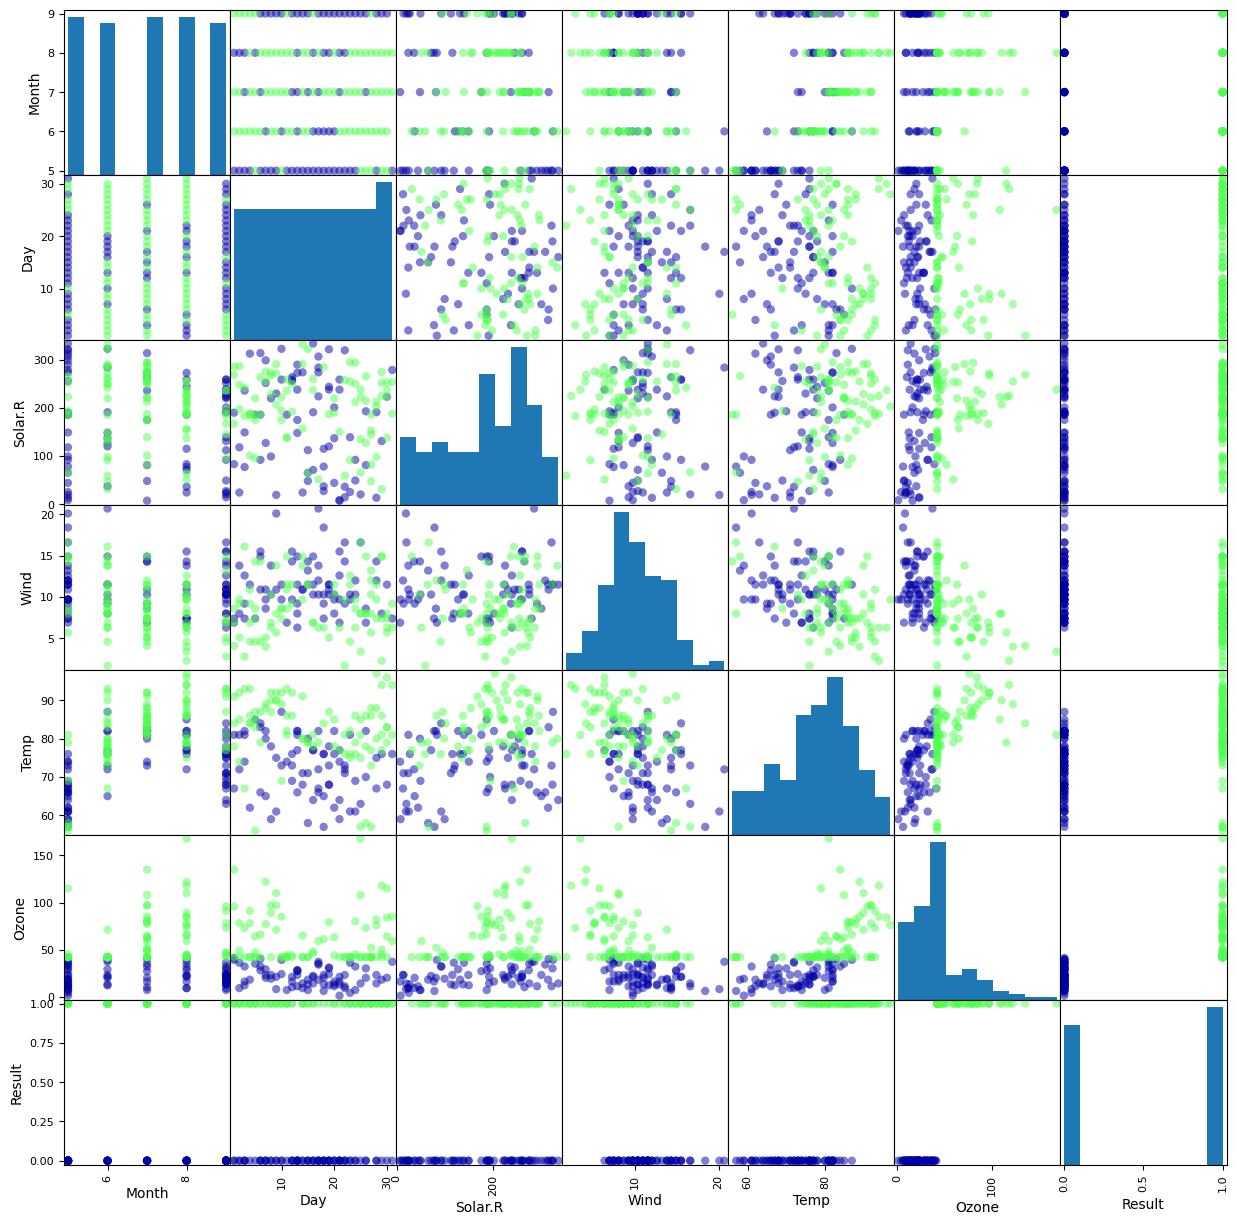

In [4]:
import mglearn
import matplotlib.pyplot as plt

#산점도 행렬 출력
pd.plotting.scatter_matrix(df, c=y, figsize=(15, 15),marker='o', cmap=mglearn.cm3)
plt.show()

In [5]:
#언더샘플링

from imblearn.under_sampling import RandomUnderSampler

X_sample, y_sample = RandomUnderSampler(random_state=0).fit_resample(X, y)

X_samp = pd.DataFrame(data=X_sample,columns=cols )
y_samp = pd.DataFrame(data=y_sample,columns=['Result'])

df_samp=pd.concat([X_samp,y_samp],axis=1)
df_samp["Result"].value_counts()

Result
0    72
1    72
Name: count, dtype: int64

In [6]:
X = X_samp[cols]
y = y_samp['Result']

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=10)

In [8]:
from sklearn.svm import SVC

model = SVC(random_state=10)
model.fit(X_train, y_train)

SVC(random_state=10)

In [9]:
import numpy as np

pred=model.predict(X_test)

print("학습용:",model.score(X_train, y_train))
print("검증용:",model.score(X_test, y_test))

학습용: 0.6608695652173913
검증용: 0.5862068965517241


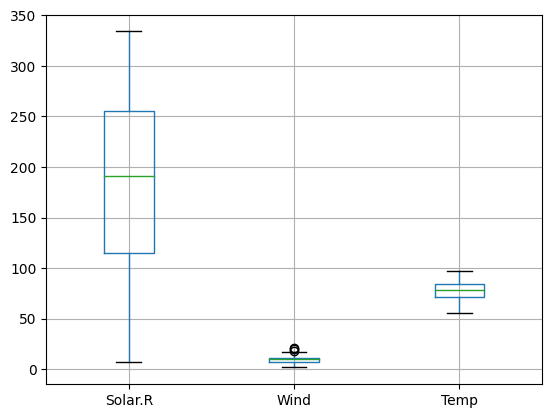

In [10]:
X_train.boxplot()

plt.show()

In [11]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(X_train)

X_train_scaled = pd.DataFrame(ss.transform(X_train))
X_test_scaled = pd.DataFrame(ss.transform(X_test))

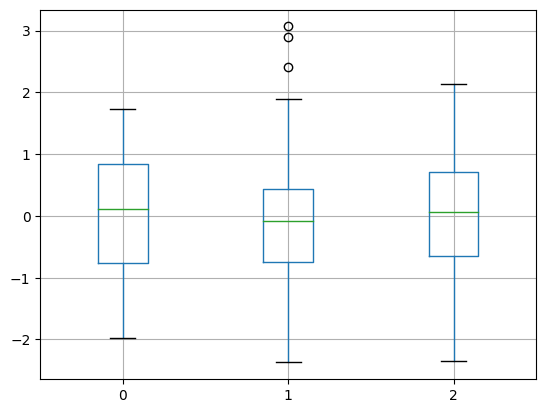

In [12]:
X_train_scaled.boxplot()
plt.show()

In [13]:
model = SVC(random_state=10)
model.fit(X_train_scaled, y_train)

print("학습용:",model.score(X_train_scaled, y_train))
print("검증용:",model.score(X_test_scaled, y_test))
#예측률이 개선됨

학습용: 0.7565217391304347
검증용: 0.7931034482758621


In [14]:
#최적의 C value와 gamma value를 찾는 과정

#최적의 C value
#C값을 증가시키면 모델이 좀더 복잡해짐(좀더 자세하게 결정경계를 찾아내는 방식)
#C값이 작으면 이상치들이 있을 가능성을 크게 잡아서 일반적인 결정 경계를 만들어낸다.

#최적의 gamma value
#gamma값을 증가시키면 각각의 데이터 포인트가 영향력을 행사하는 거리가 짧아지고
#gamma값이 작으면 영향력을 행사하는 거리가 길어진다.
#너무 크면 과대적합의 위험이 있고 너무 작으면 과소적합의 위험이 있음

import numpy as np

train_rate = []
test_rate = []

c_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
g_values = [0.0001, 0.001, 0.01, 0.1]

for n in c_values:
    for g in g_values:
        # 모델 생성
        model = SVC(C=n,gamma=g,random_state=10)
        model.fit(X_train_scaled, y_train)

        # 학습용 데이터셋의 정확도
        train_rate.append([n,g,model.score(X_train_scaled, y_train)])

        # 검증용 데이터셋의 정확도
        test_rate.append([n,g,model.score(X_test_scaled, y_test)])

train_arr=np.array(train_rate) #검증용 데이터셋의 정확도
test_arr=np.array(test_rate) #검증용 데이터셋의 정확도
max_rate=np.max(test_arr[:,2]) #가장 좋은 정확도
idx=np.where(test_arr[:,2] == max_rate)[0][0] #가장 성능이 좋은 인덱스

print("최적의 c:",test_rate[idx][0])
print("최적의 gamma:",test_rate[idx][1])
print("최적의 정확도:",test_rate[idx][2])

최적의 c: 0.1
최적의 gamma: 0.1
최적의 정확도: 0.7931034482758621


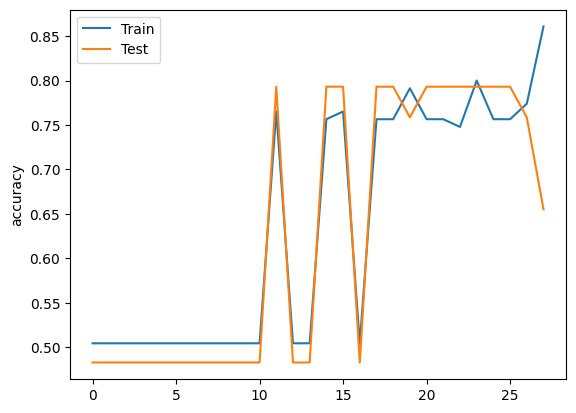

In [15]:
plt.plot(range(len(train_rate)), train_arr[:,2], label="Train")
plt.plot(range(len(test_rate)), test_arr[:,2], label="Test")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [16]:
#최적의 C, gamma value를 적용한 모형

model = SVC(C=100,gamma=0.01,random_state=10)
model.fit(X_train_scaled, y_train)

SVC(C=100, gamma=0.01, random_state=10)

In [17]:
print("학습용:",model.score(X_train_scaled, y_train))
print("검증용:",model.score(X_test_scaled, y_test))
#예측률이 개선됨

학습용: 0.7478260869565218
검증용: 0.7931034482758621


In [18]:
#confusion matrix(혼동행렬, 오분류표) 출력

from sklearn.metrics import confusion_matrix

pred=model.predict(X_test_scaled)

confusion_matrix(y_test, pred)

#           0   1
#   0    [[10,  4],
#   1    [ 2, 13]]

array([[10,  4],
       [ 2, 13]], dtype=int64)

In [19]:
from sklearn.metrics import classification_report  

print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.83      0.71      0.77        14
           1       0.76      0.87      0.81        15

    accuracy                           0.79        29
   macro avg       0.80      0.79      0.79        29
weighted avg       0.80      0.79      0.79        29

